In [1]:
import pandas as pd
import numpy as np
from sargas import *
import matplotlib.pyplot as plt
from multiprocessing import Pool
%matplotlib inline

# NPT

In [20]:
# Helper functions to build and run simulations

def build_npt(n, p, t, initial_density, rc, tail_correction):
    potential = Potential.lennard_jones(1.0, 1.0, rc, tail_correction=True)
    configuration = Configuration.from_lattice(n, initial_density)
    system = System(configuration, potential)
    displace_particle = MCMove.displace_particle(0.1, 0.4, t)
    change_volume = MCMove.change_volume(0.025, 0.5, p, t)
    
    mc = MonteCarlo([displace_particle, change_volume], [n, 1], t)
    simulation = Simulation.monte_carlo(system, mc, n)
    return simulation, system

def run_simulation(simulation, equilibration, production):
    simulation.run(equilibration)
    simulation.deactivate_propagator_updates()
    
    properties = Observer.properties(1000)
    simulation.add_observer(properties)
    
    simulation.run(production)
    return pd.DataFrame(properties.data)

def run_tp(t, p):
    nparticles = 500
    initial_density = 8e-1
    rc = 3.0
    tail_correction = True
    sim, sys = build_npt(500, p, t, initial_density, rc, True)
    properties = run_simulation(sim, 500*5000, 500*50000)
    return t, p, properties

In [ ]:
%%time
states = [
    (9e-1, 8e-1),
    (9e-1, 2.0)
]

with Pool() as pool:
    res = pool.starmap(run_tp, states)

In [29]:
res[0].density.mean(), res[1].density.mean()

(0.8942969660191653, 0.8964075831513043)

In [33]:
t1 = 9e-1
p1 = 8e-1
props1 = res[0]

t2 = 9e-1
p2 = 8.5e-1
props2 = res[1]

# Physical Validation

In [34]:
import physical_validation as pv

In [42]:
units = pv.data.UnitData(
    kb=1.0,
    energy_str='eps',
    energy_conversion=1.0,
    length_str='sigma',
    length_conversion=1.0,
    volume_str='sigma3',
    volume_conversion=1.0,
    temperature_str='T*',
    temperature_conversion=1.0,
    pressure_str='p*',
    pressure_conversion=1.0,
    time_str='t*',
    time_conversion=1.0
)

sd1 = pv.data.SimulationData()
sd1.system = pv.data.SystemData(
    natoms=nparticles,
)
sd1.units = units
sd1.ensemble = pv.data.EnsembleData(
    ensemble="NPT",
    natoms=nparticles,
    pressure=p1,
    temperature=t1
)
sd1.observables = pv.data.ObservableData(
    potential_energy=props1.energy,
    volume=props1.volume
)


sd2 = pv.data.SimulationData()
sd2.system = pv.data.SystemData(
    natoms=nparticles,
)
sd2.units = units
sd2.ensemble = pv.data.EnsembleData(
    ensemble="NPT",
    natoms=nparticles,
    pressure=p2,
    temperature=t2
)
sd2.observables = pv.data.ObservableData(
    potential_energy=props2.energy,
    volume=props2.volume
)

After equilibration, decorrelation and tail pruning, 1.60% (401 frames) of original Trajectory 1 remain.
After equilibration, decorrelation and tail pruning, 1.60% (400 frames) of original Trajectory 2 remain.
Overlap is 99.0% of trajectory 1 and 100.0% of trajectory 2.
Rule of thumb estimates that dP = 6.8 would be optimal (currently, dP = 0.0)
Maximum Likelihood Analysis (analytical error)
Free energy
    40.88528 +/- 11.25040
Estimated slope                  |  True slope
    -0.073210 +/- 0.020148       |  -0.003346
    (3.47 quantiles from true slope)
Estimated dP                     |  True dP
    1.1    +/- 0.3               |  0.0   


/usr/ITT/bauer/PhD/Code/sargas/sargas_venv/lib/python3.8/site-packages/physical_validation/util/plot.py:147: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[3.4675176280858073]

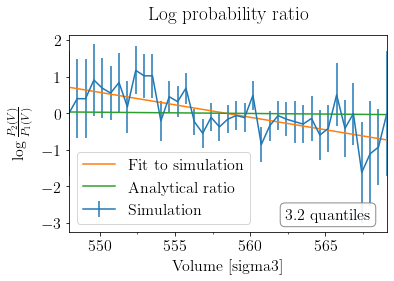

In [43]:
pv.ensemble.check(
    data_sim_one=sd1,
    data_sim_two=sd2,
    screen=True
)

In [44]:
p2, p1

(0.85, 0.8)